#TAREA 3
**Estudiante: Kevin Orlando Murcia Morales**  
**Tema:**  Clasificación de datos utilizando imágenes  
**Fecha entrega:** 05/25/2025 11:55 PM
**Objetivo:** Utilizar modelos de redes convolucionales para clasificación .
**Entrega:** Crear una rama utilizando el mismo repositorio de la tarea 1 y 2, crear otra carpeta
llamada tarea 3, solucionar el problema y crear un pull request sobre la master donde me debe
poner como reviewer (entregas diferentes  tienen una reducción de 0.5 puntos)

Como estoy trabajando desde google colab le voy a dar acceso a mi drive que es donde tengo un archivo ".zip" en el que están los datos de entrenamiento y prueba

In [6]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
!cp "/content/drive/MyDrive/Colab Notebooks/data.zip" /content/

In [8]:
# Descomprimir el ZIP
!unzip -q data.zip
print("¡Datos extraídos correctamente!")


¡Datos extraídos correctamente!


##El objetivo es utilizar las imágenes de training para entrenar una red convolucional como la que vimos en clase. Se deben crear 2 modelos, uno es una regresión logística y el otro una red convolucional. Se deben hacer 2 envíos en kaggle uno con los resultados de la regresión y los otros con la convolución.

In [10]:
#CARGAR LIBRERÍAS
import numpy as np
import pandas as pd
import cv2
import os
import glob
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from google.colab import files

# CARGAR Y PROCESAR DATOS
def cargar_datos_con_etiquetas(ruta, tamaño=(64, 64)):
    X, y = [], []
    clases = sorted([d for d in os.listdir(ruta) if os.path.isdir(os.path.join(ruta, d))])
    clase_map = {nombre: i for i, nombre in enumerate(clases)}
    print("Etiquetas encontradas:", clase_map)

    for clase in clases:
        archivos = glob.glob(os.path.join(ruta, clase, '*'))
        for archivo in archivos:
            img = cv2.imread(archivo)
            if img is not None:
                img = cv2.resize(img, tamaño)
                X.append(img)
                y.append(clase_map[clase])
    return np.array(X, dtype=np.float32) / 255.0, np.array(y), clase_map

def cargar_test(ruta, tamaño=(64, 64)):
    X_test = []
    nombres = []
    for archivo in sorted(glob.glob(os.path.join(ruta, '*'))):
        img = cv2.imread(archivo)
        if img is not None:
            img = cv2.resize(img, tamaño)
            X_test.append(img)
            nombres.append(os.path.basename(archivo))
    return np.array(X_test, dtype=np.float32) / 255.0, nombres

In [11]:
# REGRESIÓN LOGÍSTICA DESDE CERO
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def loss(y, y_hat):
    m = len(y)
    return -1/m * np.sum(y * np.log(y_hat + 1e-15) + (1 - y) * np.log(1 - y_hat + 1e-15))

def entrenar_logistica(X, y, lr=0.05, epochs=500):
    m, n = X.shape
    W, b = np.zeros(n), 0
    for epoch in range(epochs):
        z = X @ W + b
        y_hat = sigmoid(z)
        W -= lr * (X.T @ (y_hat - y)) / m
        b -= lr * np.sum(y_hat - y) / m
    return W, b

def entrenar_ovr(X, y, clases):
    modelos = {}
    for c in clases:
        y_bin = (y == c).astype(int)
        W, b = entrenar_logistica(X, y_bin)
        modelos[c] = (W, b)
    return modelos

def predecir_ovr(X, modelos):
    scores = [sigmoid(X @ W + b) for W, b in modelos.values()]
    return np.argmax(np.stack(scores, axis=1), axis=1)


In [12]:
# ENTRENAMIENTO
X, y, clase_map = cargar_datos_con_etiquetas("data/train")
Xtrain, Xval, ytrain, yval = train_test_split(X, y, test_size=0.2)

# Regresión logística
Xtrain_flat = Xtrain.reshape(len(Xtrain), -1)
Xval_flat = Xval.reshape(len(Xval), -1)
modelo_log = entrenar_ovr(Xtrain_flat, ytrain, np.unique(ytrain))
pred_log = predecir_ovr(Xval_flat, modelo_log)

# Red convolucional
ytrain_cat = to_categorical(ytrain)
yval_cat = to_categorical(yval)

cnn = Sequential([
    Conv2D(16, (3,3), activation='relu', input_shape=(64, 64, 3)),
    MaxPooling2D((2,2)),
    Conv2D(32, (3,3), activation='relu'),
    MaxPooling2D((2,2)),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(len(clase_map), activation='softmax')
])

cnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
cnn.fit(Xtrain, ytrain_cat, epochs=10, validation_data=(Xval, yval_cat))




Etiquetas encontradas: {'Black-grass': 0, 'Charlock': 1, 'Cleavers': 2, 'Common Chickweed': 3, 'Common wheat': 4, 'Fat Hen': 5, 'Loose Silky-bent': 6, 'Maize': 7, 'Scentless Mayweed': 8, 'Shepherds Purse': 9, 'Small-flowered Cranesbill': 10, 'Sugar beet': 11, 'cat': 12, 'cow': 13, 'dog': 14, 'horse': 15}


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
136/136 ━━━━━━━━━━━━━━━━━━━━ 18s 111ms/step - accuracy: 0.1215 - loss: 2.6460 - val_accuracy: 0.1525 - val_loss: 2.2837
Epoch 2/10
136/136 ━━━━━━━━━━━━━━━━━━━━ 20s 107ms/step - accuracy: 0.1830 - loss: 2.2746 - val_accuracy: 0.1839 - val_loss: 2.2149
Epoch 3/10
136/136 ━━━━━━━━━━━━━━━━━━━━ 20s 107ms/step - accuracy: 0.2500 - loss: 2.1365 - val_accuracy: 0.3152 - val_loss: 1.9666
Epoch 4/10
136/136 ━━━━━━━━━━━━━━━━━━━━ 21s 108ms/step - accuracy: 0.4010 - loss: 1.8039 - val_accuracy: 0.4732 - val_loss: 1.5599
Epoch 5/10
136/136 ━━━━━━━━━━━━━━━━━━━━ 21s 110ms/step - accuracy: 0.5207 - loss: 1.4572 - val_accuracy: 0.5111 - val_loss: 1.4422
Epoch 6/10
136/136 ━━━━━━━━━━━━━━━━━━━━ 15s 108ms/step - accuracy: 0.5891 - loss: 1.2598 - val_accuracy: 0.5656 - val_loss: 1.3048
Epoch 7/10
136/136 ━━━━━━━━━━━━━━━━━━━━ 20s 105ms/step - accuracy: 0.6314 - loss: 1.1172 - val_accuracy: 0.6201 - val_loss: 1.1628
Epoch 8/10
136/136 ━━━━━━━━━━━━━━━━━━━━ 15s 107ms/step - accuracy: 0.7054 - loss: 0

##Después de entrenar el modelo, se utiliza el dataset de testing para clasificar las imágenes, y producir un archivo csv donde la primera columna es el nombre de la imagen y la segunda la categoría como se muestra en la siguiente imagen.

In [13]:
#GENERAR ARCHIVOS CSV
Xtest, nombres_test = cargar_test("data/test")

# CNN
pred_test_cnn = cnn.predict(Xtest)
pred_final_cnn = np.argmax(pred_test_cnn, axis=1)
inv_map = {v: k for k, v in clase_map.items()}
labels_final = [inv_map[i] for i in pred_final_cnn]
pd.DataFrame({"image": nombres_test, "label": labels_final}).to_csv("cnn_KOMM.csv", index=False)
files.download("cnn_KOMM.csv")

# Regresión logística
pred_test_rl = predecir_ovr(Xtest.reshape(len(Xtest), -1), modelo_log)
labels_rl = [inv_map[i] for i in pred_test_rl]
pd.DataFrame({"image": nombres_test, "label": labels_rl}).to_csv("Regresion_logistica_KOMM.csv", index=False)
files.download("Regresion_logistica_KOMM.csv")

31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

##por último realice el envío y recibirá el score del accuracy. Entre más alto mejor es el modelo y aparecerás en la primera posición en el tablero. Compare el accuracy de los 2 modelos y realice una matriz de confusión.

34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step
Accuracy Regresión Logística: 0.2477
Accuracy Red Convolucional: 0.6913


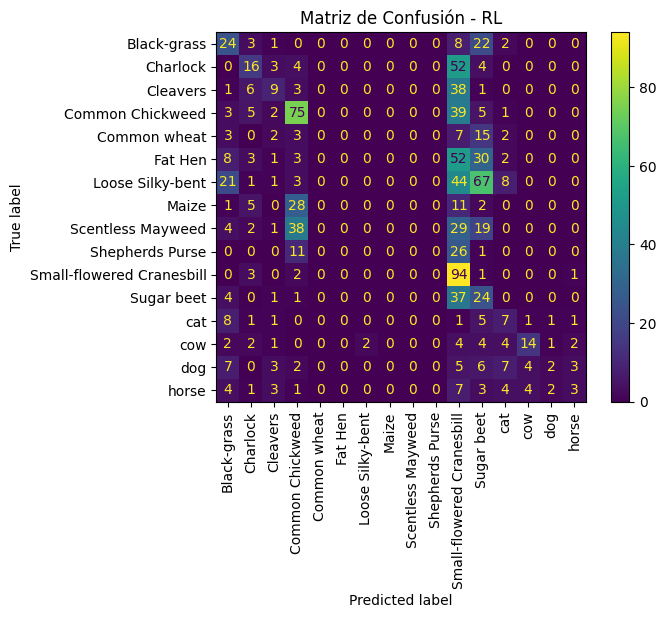

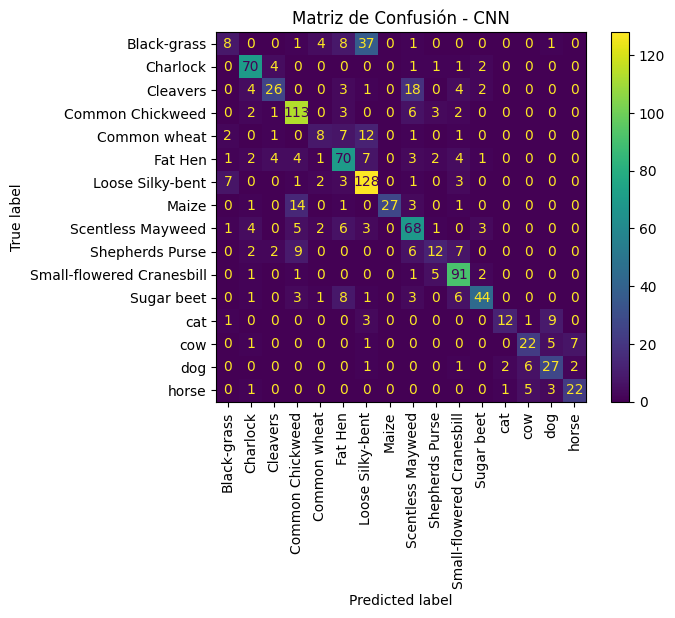

In [14]:
# COMPARACIÓN DE MODELOS
pred_cnn = np.argmax(cnn.predict(Xval), axis=1)

acc_rl = accuracy_score(yval, pred_log)
acc_cnn = accuracy_score(yval, pred_cnn)

print(f"Accuracy Regresión Logística: {acc_rl:.4f}")
print(f"Accuracy Red Convolucional: {acc_cnn:.4f}")

ConfusionMatrixDisplay(confusion_matrix(yval, pred_log), display_labels=clase_map.keys()).plot()
plt.title("Matriz de Confusión - RL")
plt.xticks(rotation=90)
plt.show()

ConfusionMatrixDisplay(confusion_matrix(yval, pred_cnn), display_labels=clase_map.keys()).plot()
plt.title("Matriz de Confusión - CNN")
plt.xticks(rotation=90)
plt.show()


La red convolucional supera ampliamente a la regresión logística en precisión y capacidad de distinguir entre clases visualmente similares. Es el modelo claramente más efectivo para este problema de clasificación de imágenes.